In [1]:
import tensorflow as tf
import numpy as np
from utils import *
import matplotlib
from collections import Counter
import itertools
from rnaseqdb import *
import pickle
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from matplotlib.collections import EllipseCollection
import umap
import requests
import json
from sklearn.cluster import KMeans
import networkx as nx

# UMAP representation

/anaconda3/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


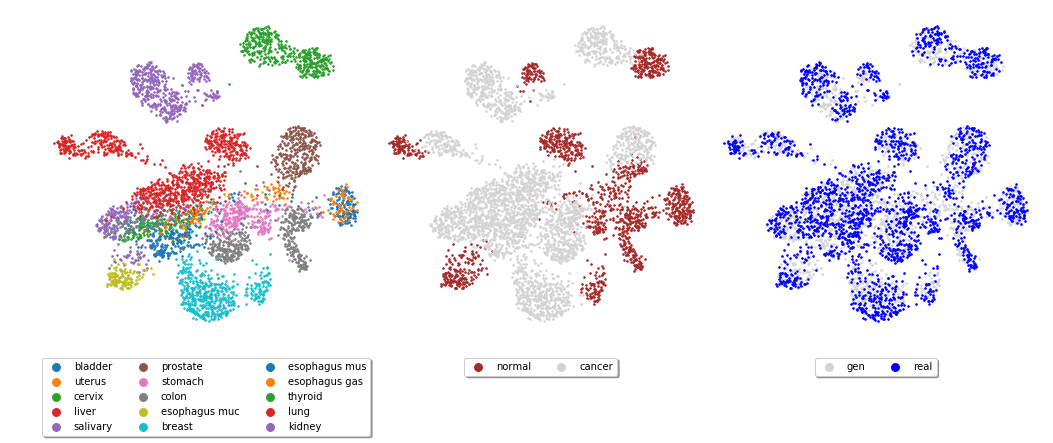

In [2]:
# Load data
with open('data/rnaseqdb_gen.pkl', 'rb') as f:
    data = pickle.load(f)

x_test = data['x_test']
x_gen = data['x_gen']
tissues_dict_inv = data['tissues_dict_inv']
tissues_dict_inv = [t.replace('_', ' ') for t in tissues_dict_inv]
dataset_dict_inv = data['dataset_dict_inv']
cat_covs_test = data['cat_covs_test']
tissue = np.array([tissues_dict_inv[t] for t in cat_covs_test[:, 0]])

x = np.concatenate((x_test, x_gen), axis=0)
t = np.concatenate((tissue, tissue), axis=0)
s = np.array(['real'] * x_test.shape[0] + ['gen'] * x_test.shape[0])
c = np.array(['normal' if dataset_dict_inv[q] != 'tcga-t' else 'cancer' for q in cat_covs_test[:, 1]])
c = np.concatenate((c, c), axis=0)
d = np.concatenate((cat_covs_test[:, 1], cat_covs_test[:, 1]), axis=0)

# Perform UMAP
model = umap.UMAP(n_neighbors=300,
                   min_dist=0.7,
                   random_state=1111)
model.fit(x)
emb_2d = model.transform(x)

# Plot
plt.figure(figsize=(18, 6))
ax = plt.gca()

plt.subplot(1, 3, 1)
# ax = scatter_2d(emb_2d, t, s=30, marker='.')
colors =  plt.get_cmap('tab20').colors
# scatter_2d_cancer(emb_2d, t, c, colors=colors)
ax = scatter_2d(emb_2d, t, s=10, marker='.')

lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, markerscale=5)
plt.axis('off')

plt.subplot(1, 3, 2)
colors = ['brown', 'lightgray']
ax = scatter_2d(emb_2d, c, colors=colors, s=10, marker='.')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, markerscale=5)
plt.axis('off')

plt.subplot(1, 3, 3)
colors = ['lightgray', 'blue']
ax = scatter_2d(emb_2d, s, colors=colors, s=10, marker='.')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, markerscale=5)
plt.axis('off')

plt.subplots_adjust(wspace=0)
plt.savefig('figures/UMAP_combined.pdf', bbox_extra_artists=(lgd,),  bbox_inches='tight');

# Global clustering and gene ontologies analysis

In [3]:
def overrepresented_ontologies(gene_list, fdr_threshold=0.05, positive_enrichment=True):
    parameters = {'geneInputList': ','.join(gene_list), 'organism': 9606, 'annotDataSet': 'GO:0008150'}
    # Make a get request with the parameters.
    response = requests.post('http://pantherdb.org/services/oai/pantherdb/enrich/overrep', params=parameters)
    # Print the content of the response (the data the server returned)
    out = json.loads(response.content)
    ontologies = []
    for result in out['results']['result']:
        if 'term' in result and 'id' in result['term']:
            go = result['term']['id']
            label = result['term']['label']
            pvalue = result['pValue']
            fdr = result['fdr']
            sign = result['plus_minus']
            if fdr <= fdr_threshold:
                if positive_enrichment and sign == '+':
                    ontologies.append((go, fdr, pvalue, label, sign))
                elif not positive_enrichment:
                    ontologies.append((go, fdr, pvalue, label, sign))
    return ontologies

def annotate_ontologies(t, ontologies_r, ontologies_s, cluster_map, pos, n_clust = 10, n_ont = 12, onts_perline = 4, x_offset=-0.75, y_offset=-0.5):
    if t=='R':
        ontologies = ontologies_r
        ontologies_opposite = ontologies_s
    else:
        ontologies = ontologies_s
        ontologies_opposite = ontologies_r
    
    labels = dict()
    for i in range(n_clust):
        go, fdr = ontologies[i]
        k = '{}{}'.format(t, i)
        # v = ','.join([' {} ({})'.format(go[k], np.format_float_scientific(fdr[k], precision=1, exp_digits=1)) for k in range(min(n_ont, len(go)))])

        nb_ont = len(go)
        nb_ont_lim = min(n_ont, nb_ont)
        v = ''
        for j in range(n_ont):
            if (j == n_ont - 1) and nb_ont > n_ont:
                v += '[...]'
            elif j < nb_ont:
                if go[j] in ontologies_opposite[cluster_map[i]][0]:
                    v += '$\mathbf{'+ go[j] + '}$'
                else:
                    v += go[j]
                if j != nb_ont - 1:
                    v += ', '
            if (j+1) % onts_perline == 0:
                v += "\n"    
        labels[k] = v

    # labels = {'R0': r'$\mathbf{GO:0009987}$ ($4 · 10^{-2}$), GO:0009593 (1.31E-02)'}
    for k, v in labels.items():
        pos_ = pos[k]
        plt.text(pos_[0]+x_offset,pos_[1]+y_offset,s=v, horizontalalignment='left');

In [4]:
# Load data
expr_df, info_df = rnaseqdb_load()
symbols = np.array([s[0] for s in expr_df.index])

# KMeans real
kmeans = KMeans(n_clusters=10)
kmeans = kmeans.fit(x_test.T)

# KMeans gan
kmeans_gen = KMeans(n_clusters=10)
kmeans_gen = kmeans_gen.fit(x_gen.T)

# Build graph
G = nx.Graph()
G.add_nodes_from(['R{}'.format(i) for i in range(10)] + ['S{}'.format(i) for i in range(10)])
max_edges = []

ontologies_r = []
ontologies_s = []

for i in range(10):
    genes_real = set(symbols[kmeans.labels_==i])
    r_name = 'R{}'.format(i)
    G.node[r_name]['name'] = len(genes_real)
    print('Real cluster: {}. ({})'.format(i, len(genes_real)))
    
    # Obtain enriched ontologies for real clusters
    out = overrepresented_ontologies(symbols[kmeans.labels_==i], fdr_threshold=0.05)
    if len(out) == 0:
        ontologies_r.append([[], []])
    else:
        out_ = list(map(list, zip(*out)))
        go, fdr, _, _, _ = out_
        idxs = np.argsort(fdr)
        ontologies_r.append([np.array(go)[idxs], np.array(fdr)[idxs]])
    
    # Obtain enriched ontologies for synthetic clusters
    out = overrepresented_ontologies(symbols[kmeans_gen.labels_==i], fdr_threshold=0.05)
    if len(out) == 0:
        ontologies_s.append([[], []])
    else:
        out_ = list(map(list, zip(*out)))
        go, fdr, _, _, _ = out_
        idxs = np.argsort(fdr)
        ontologies_s.append([np.array(go)[idxs], np.array(fdr)[idxs]])
    
    max_common = 0
    s_max = None
    for j in range(10):
        s_name = 'S{}'.format(j)
        genes_gen = set(symbols[kmeans_gen.labels_==j])
        G.node[s_name]['name'] = len(genes_gen)
        common_genes = genes_real.intersection(genes_gen)
        if len(common_genes) > max_common:
            max_common = len(common_genes)
            s_max = s_name
        G.add_edge(r_name, s_name, weight=len(common_genes) / len(genes_real))
        print('Gen cluster: {}. ({}). Common genes: {}'.format(j, len(symbols[kmeans_gen.labels_==j]), len(common_genes)))
    
    print()    
    max_edges.append((s_max, max_common))

edge_labels = {('R{}'.format(r), s): n for r, (s, n) in enumerate(max_edges)}


# Plot graph
left_nodes, right_nodes = nx.bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(left_nodes)) # put nodes from X at x=1
# pos.update( (n, (1, int(n[1:]))) for i, n in enumerate(left_nodes)) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(right_nodes)) # put nodes from Y at x=2
fixed_pos = pos.copy()

fig = plt.figure(figsize=(7, 7))

# Add ontologies
ont_r_nodes = set()
for i, ont_r in enumerate(ontologies_r):
    # print(ont_r[0])
    
    for ont_r_go, ont_r_fdr in list(map(list, zip(*ont_r))):
        # print(ont_r_go)
        # print(ont_r_fdr)
        G.add_node(ont_r_go)
        G.node[ont_r_go]['name'] = ont_r_go
        G.add_edge(ont_r_go, 'R{}'.format(i), weight=1)
        ont_r_nodes.add(ont_r_go)
H = G.subgraph(list(ont_r_nodes))
pos_ont_r = nx.spring_layout(H)  # nx.circular_layout(H)
for k, v in pos_ont_r.items():
    pos_ont_r[k] = (1.5, 5) + v*(1.5, 10)
pos.update(pos_ont_r)

ont_s_nodes = set()
for i, ont_s in enumerate(ontologies_s):
    for ont_s_go, ont_s_fdr in list(map(list, zip(*ont_s))):
        # print(ont_r_go)
        # print(ont_r_fdr)
        G.add_node(ont_s_go)
        G.node[ont_s_go]['name'] = ont_s_go
        G.add_edge(ont_s_go, 'S{}'.format(i), weight=1)
        ont_r_nodes.add(ont_s_go)
H = G.subgraph(list(ont_s_nodes))
pos_ont_s = nx.spring_layout(H)  # nx.circular_layout(H)
for k, v in pos_ont_s.items():
    pos_ont_s[k] = (1.5, 5) + v*(1.5, 10)
pos.update(pos_ont_s)


H = G
H = G.subgraph(fixed_pos.keys())
color_map = ['lightblue' if n.startswith('R') else 'orange' if  n.startswith('S')  else 'salmon'  for n in H]
weights = [H[u][v]['weight'] for u,v in H.edges()]
nx.draw(H, labels=nx.get_node_attributes(H, 'name'),
        pos=pos, width=weights,
        node_color=color_map,
        node_size=1000,
        with_labels = True)
nx.draw_networkx_edge_labels(H, pos=pos, edge_labels=edge_labels, label_pos=0.92)

cluster_map = [int(max_edges[j][0][1:]) for j in range(10)]
cluster_map_inv = [cluster_map.index(j) for j in range(10)]
annotate_ontologies('R', ontologies_r, ontologies_s, cluster_map, pos, x_offset=-0.8)
annotate_ontologies('S', ontologies_r, ontologies_s, cluster_map_inv, pos, x_offset=+0.07)

# plt.tight_layout()
plt.savefig('figures/kmeans_ontologies.pdf', dpi=fig.dpi, bbox_inches = 'tight', pad_inches = 0);

# pos_ = {k: (v[0] - 2, v[1]) for k, v in pos.items()}
# nx.draw_networkx_labels(G, pos=pos_, labels={n:lab for n,lab in labels.items() if n in pos});

... loading RNASeqDB dataset
Real cluster: 0. (1454)


ConnectionError: HTTPConnectionPool(host='pantherdb.org', port=80): Max retries exceeded with url: /services/oai/pantherdb/enrich/overrep?geneInputList=AADAT%2CABCA1%2CABCA9%2CABCG2%2CABHD14A%2CABTB1%2CAC002398.9%2CAC004466.1%2CAC005003.1%2CAC007919.2%2CAC009065.1%2CAC010336.1%2CAC010536.1%2CAC011484.1%2CAC012414.1%2CAC024940.1%2CAC027228.1%2CAC073343.1%2CAC092291.2%2CAC117395.1%2CAC136297.1%2CACAA1%2CACAP2%2CACAP3%2CACHE%2CACOT11%2CACPT%2CACSF2%2CACSF3%2CACTL6B%2CACTR1A%2CADAM10%2CADAMTS17%2CADAMTSL1%2CADAMTSL4-AS1%2CADCYAP1R1%2CADD1%2CADIG%2CADNP%2CADO%2CADORA3%2CADSSL1%2CAEBP2%2CAFF2%2CAFF3%2CAFM%2CAGAP6%2CAGGF1%2CAGMAT%2CAGO2%2CAGO4%2CAGR3%2CAGXT%2CAJAP1%2CAKIP1%2CAKR1A1%2CAKR1B1%2CAKR1C2%2CAL354718.1%2CAL356356.1%2CAL358113.1%2CAL359736.1%2CAL583828.1%2CAL589739.1%2CAL627171.2%2CAL645608.1%2CALAS2%2CALDOA%2CALG2%2CALKBH8%2CALOX15B%2CALOX5%2CALOX5AP%2CALX1%2CAMD1%2CAMER1%2CAMY1C%2CANGPTL1%2CANKHD1%2CANKRD20A3%2CANKRD34B%2CANKRD44%2CANO1%2CANP32A%2CAP000322.53%2CAP000974.1%2CAP001816.1%2CAP4S1%2CAPOBEC3A%2CAPOF%2CAPOL1%2CAPOL2%2CAR%2CAREGB%2CARFGAP2%2CARFRP1%2CARG1%2CARHGAP25%2CARHGAP32%2CARHGDIB%2CARHGDIG%2CARHGEF19%2CARIH1%2CARL1%2CARL16%2CARL6IP5%2CARMC6%2CARRB1%2CARSA%2CARSE%2CARSI%2CART5%2CASB11%2CASCL3%2CASF1B%2CASGR2%2CASMTL%2CASNA1%2CASPDH%2CATF1%2CATF2%2CATF6%2CATF7IP2%2CATG4A%2CATOH7%2CATOH8%2CATOX1%2CATP10B%2CATP11A%2CATP13A1%2CATP13A3%2CATP2A2%2CATP2A3%2CATP5G3%2CATP5J2%2CATP6V1D%2CATP6V1E2%2CATP8B3%2CATP8B4%2CATR%2CATXN7L1%2CATXN7L2%2CAVP%2CB3GALNT1%2CB3GNT3%2CB3GNT9%2CB4GALNT4%2CB4GALT5%2CBAHD1%2CBANF1%2CBAZ1A%2CBCL2L15%2CBCL7C%2CBCOR%2CBCR%2CBDKRB1%2CBEND3%2CBFSP1%2CBFSP2%2CBHMT2%2CBIRC6%2CBLK%2CBLOC1S5%2CBMP8B%2CBMPR1A%2CBMS1%2CBNC1%2CBOLA1%2CBRINP3%2CBRSK1%2CBRWD3%2CBTBD3%2CBTBD9%2CBTD%2CBX649567.1%2CC10orf111%2CC10orf118%2CC10orf25%2CC10orf32%2CC10orf91%2CC10orf99%2CC11orf73%2CC12orf74%2CC14orf1%2CC14orf132%2CC14orf159%2CC17orf47%2CC17orf67%2CC18orf32%2CC19orf10%2CC19orf12%2CC19orf69%2CC19orf71%2CC1QL4%2CC1QTNF9%2CC1R%2CC1orf115%2CC1orf134%2CC1orf172%2CC1orf35%2CC1orf54%2CC21orf88%2CC22orf31%2CC22orf46%2CC2orf74%2CC3orf33%2CC3orf35%2CC4BPA%2CC5orf15%2CC6orf120%2CC6orf99%2CC7orf10%2CC7orf73%2CC8orf37%2CC8orf48%2CC8orf59%2CC8orf76%2CC9orf117%2CC9orf66%2CC9orf72%2CC9orf96%2CCA5B%2CCABIN1%2CCABLES1%2CCACNA1A%2CCACNA1F%2CCACNB4%2CCAD%2CCAGE1%2CCALB1%2CCALCA%2CCALCOCO2%2CCALR%2CCAMP%2CCAND2%2CCAP1%2CCAPN14%2CCAPNS1%2CCARKD%2CCARTPT%2CCASP16%2CCASP3%2CCASP6%2CCASQ2%2CCCAR2%2CCCDC102A%2CCCDC127%2CCCDC130%2CCCDC132%2CCCDC28A%2CCCDC33%2CCCDC6%2CCCDC65%2CCCDC86%2CCCDC96%2CCCL3L3%2CCCNB1%2CCCNE2%2CCCNL2%2CCCR7%2CCCT7%2CCD14%2CCD40LG%2CCD8A%2CCD8B%2CCD93%2CCD99L2%2CCDC20%2CCDC25C%2CCDC42%2CCDC6%2CCDCA5%2CCDH16%2CCDHR3%2CCDIP1%2CCDK1%2CCDK11A%2CCDK19%2CCDKL5%2CCDKN3%2CCDV3%2CCEACAM16%2CCEBPZ%2CCELF4%2CCELSR1%2CCELSR2%2CCELSR3%2CCEP19%2CCEP70%2CCERS5%2CCFP%2CCGNL1%2CCHCHD5%2CCHEK1%2CCHIT1%2CCHRD%2CCHRM5%2CCHRNB1%2CCHST3%2CCIAPIN1%2CCIB3%2CCIDEC%2CCISH%2CCITED4%2CCLCN4%2CCLDN2%2CCLDN3%2CCLDN4%2CCLEC2D%2CCLEC6A%2CCLSPN%2CCLTA%2CCLUL1%2CCNFN%2CCNIH4%2CCNOT4%2CCOG8%2CCOL22A1%2CCOL5A1%2CCOPS8%2CCOQ7%2CCOX14%2CCOX6A1P2%2CCPEB3%2CCPN1%2CCPSF7%2CCREBZF%2CCRIP2%2CCRIP3%2CCRIPAK%2CCRYL1%2CCSGALNACT2%2CCSNK1D%2CCT45A5%2CCT62%2CCTAGE9%2CCTB-186H2.3%2CCTD-2207O23.10%2CCTD-2260A17.2%2CCTD-2535L24.2%2CCTD-2545G14.7%2CCTD-2583A14.9%2CCTD-2616J11.11%2CCTDSPL2%2CCXCL2%2CCXCR1%2CCXorf40B%2CCYBRD1%2CCYP17A1%2CCYP27B1%2CCYP4A22%2CCYR61%2CCYTH2%2CDAB2%2CDACH1%2CDAGLA%2CDALRD3%2CDAO%2CDCC%2CDCLRE1C%2CDDC%2CDDX3Y%2CDDX47%2CDDX5%2CDEFB1%2CDEFB4A%2CDEGS1%2CDEPDC5%2CDFNB59%2CDHCR24%2CDHX15%2CDHX30%2CDHX58%2CDIABLO%2CDIAPH1%2CDKFZP547L112%2CDKK2%2CDLC1%2CDLST%2CDMRT1%2CDNAAF2%2CDNAH2%2CDNAI2%2CDNAJA1%2CDNAJC12%2CDNAJC13%2CDNAJC14%2CDNAJC19%2CDNAJC5B%2CDNAL4%2CDNM1L%2CDOCK1%2CDOCK2%2CDOCK3%2CDOPEY2%2CDPF2%2CDPF3%2CDRAM1%2CDRD2%2CDTWD2%2CDUOX2%2CDUSP11%2CEDF1%2CEDNRB%2CEEF2%2CEFCAB12%2CEFCAB13%2CEFCAB6%2CEFCAB7%2CEFNA1%2CEIF1B%2CEIF3G%2CEIF6%2CELK3%2CELP6%2CEME2%2CEML4%2CEML5%2CEMP1%2CEMP2%2CEMX1%2CENAM%2CENKUR%2CENPP2%2CENPP6%2CEPAS1%2CEPC2%2CEPHA10%2CEPHA3%2CEPHB4%2CEPOR%2CEPPK1%2CEPRS%2CEPT1%2CERBB3%2CERC1%2CEREG%2CERO1LB%2CERP29%2CERV3-1%2CERVW-1%2CESRP1%2CESYT1%2CESYT2%2CETV3%2CEVPLL%2CEXOC3L4%2CEXOSC10%2CEYA4%2CEZH2%2CF2RL3%2CFAHD2B%2CFAM105B%2CFAM127A%2CFAM129B%2CFAM214A%2CFAM219A%2CFAM26F%2CFAM49A%2CFAM57B%2CFAM69A%2CFAM84A%2CFANCI%2CFANCM%2CFASN%2CFASTKD2%2CFBN1%2CFBXO11%2CFBXO34%2CFBXW8%2CFBXW9%2CFCGR2B%2CFGD3%2CFGD6%2CFGF19%2CFGF20%2CFGFR1%2CFKBP4%2CFKSG68%2CFLJ30594%2CFMO1%2CFN1%2CFNDC5%2CFNIP2%2CFNTA%2CFOCAD%2CFOLH1%2CFOXF2%2CFOXJ1%2CFOXO3%2CFOXO4%2CFOXP3%2CFOXRED2%2CFRA10AC1%2CFRAT2%2CFSCN1%2CFUK%2CFUNDC2%2CFUT7%2CFXYD3%2CFYTTD1%2CFZR1%2CGABRA4%2CGABRG3%2CGALK2%2CGALNT15%2CGALNTL6%2CGALT%2CGBE1%2CGCLC%2CGCNT2%2CGDPD1%2CGEMIN5%2CGET4%2CGFOD1%2CGGACT%2CGIMAP2%2CGIT1%2CGJB3%2CGLB1L%2CGMFB%2CGNB1L%2CGNB5%2CGNPAT%2CGNPTG%2CGOLGA5%2CGOSR2%2CGOT2%2CGPATCH2L%2CGPATCH3%2CGPATCH4%2CGPC1%2CGPC6%2CGPCPD1%2CGPKOW%2CGPR1%2CGPR162%2CGPR180%2CGPR42%2CGPR56%2CGRHL3%2CGSG1%2CGSKIP%2CGSTM4%2CGSTM5%2CGSX2%2CGTF2F1%2CGTF2H4%2CGTF2IRD2%2CGTF3A%2CGTF3C5%2CGYG2%2CGZMA%2CH2AFB1%2CHARS2%2CHCFC2%2CHCST%2CHDAC10%2CHDGFL1%2CHELLS%2CHES1%2CHES6%2CHEXIM1%2CHEY1%2CHHEX%2CHIAT1%2CHIC2%2CHIF3A%2CHINFP%2CHINT2%2CHIST1H2AJ%2CHIST1H2AK%2CHIST1H2BD%2CHIST1H2BN%2CHIST1H3B%2CHIST1H4E%2CHIST2H2AA4%2CHMG20A%2CHMGN5%2CHMHA1%2CHOXA7%2CHOXC11%2CHOXD1%2CHSD17B11%2CHSD17B8%2CHSDL2%2CHSF2%2CHSF2BP%2CHSF4%2CHSPA13%2CHSPA9%2CHSPB3%2CHTR1D%2CHTR1E%2CHUS1%2CHYDIN%2CHYOU1%2CIDI2%2CIFI44%2CIFNAR1%2CIFRD1%2CIGBP1%2CIGF2%2CIGF2R%2CIGFLR1%2CIGLON5%2CIGSF21%2CIKZF3%2CIL17D%2CIL32%2CIMMP2L%2CINO80B%2CINPP5E%2CINSR%2CINTS2%2CINTS4%2CINTS5%2CINTS7%2CIQCH%2CIQCK%2CIRF9%2CISM2%2CITGB3BP%2CITGB7%2CITPRIP%2CITPRIPL1%2CIVL%2CIZUMO1%2CJAM3%2CJAZF1%2CJMJD6%2CKAAG1%2CKARS%2CKATNB1%2CKBTBD4%2CKCNA5%2CKCND3%2CKCNG2%2CKCNJ8%2CKCNK10%2CKCNK3%2CKCNK9%2CKCNT1%2CKCTD6%2CKDELR3%2CKIAA0391%2CKIAA0586%2CKIAA1456%2CKIAA1958%2CKIAA2013%2CKIAA2018%2CKIF13A%2CKIF18B%2CKIF1A%2CKIF26B%2CKIF9%2CKIFC3%2CKLHL23%2CKLHL42%2CKLK12%2CKPNA1%2CKRBOX4%2CKRT1%2CKRT10%2CKRT20%2CKRT77%2CKRT83%2CKRTAP1-5%2CKRTAP11-1%2CKRTAP2-3%2CL34079.2%2CL3MBTL3%2CLAG3%2CLAIR1%2CLAMA3%2CLAMP2%2CLAMTOR5%2CLARP7%2CLBR%2CLCE2C%2CLCLAT1%2CLCN1%2CLDOC1%2CLEAP2%2CLFNG%2CLGALS14%2CLGALS2%2CLGALSL%2CLGR5%2CLGR6%2CLHB%2CLHFPL1%2CLILRB2%2CLIN9%2CLINC00908%2CLINS%2CLIPC%2CLMO2%2CLNX1%2CLOXL1%2CLPAR3%2CLPCAT3%2CLPIN3%2CLRFN2%2CLRFN3%2CLRGUK%2CLRIF1%2CLRPAP1%2CLRRC10B%2CLRRC25%2CLRRC37B%2CLRRC4%2CLRRC42%2CLRRC47%2CLRRC56%2CLRRC8E%2CLRWD1%2CLSG1%2CLSM12%2CLSR%2CLTB%2CLTN1%2CLUC7L2%2CLY6G5C%2CLYAR%2CLYPD5%2CLYPD6%2CM6PR%2CMAFA%2CMAN2B2%2CMAOA%2CMAP10%2CMAP1S%2CMAP2K1%2CMAP3K13%2CMAP3K3%2CMAPK7%2CMAPK8IP2%2CMAPKBP1%2CMARC2%2CMARCH3%2CMARVELD2%2CMAT2B%2CMATN2%2CMBNL3%2CMCFD2%2CMCM6%2CMCRS1%2CMDFI%2CMED12L%2CMED28%2CMEF2C%2CMEST%2CMETTL17%2CMFAP2%2CMFAP3%2CMFAP3L%2CMFN1%2CMFSD2B%2CMGA%2CMGAM%2CMIA2%2CMID2%2CMKNK2%2CMLF1%2CMLF1IP%2CMLK4%2CMMEL1%2CMMP15%2CMMP19%2CMMP20%2CMOK%2CMORC4%2CMPL%2CMPND%2CMPV17L2%2CMRAP2%2CMRC1%2CMRFAP1%2CMRGPRF%2CMROH2A%2CMRPL14%2CMRPL47%2CMRPS18B%2CMRPS24%2CMS4A2%2CMSR1%2CMT-ND4%2CMTAP%2CMTDH%2CMTRF1L%2CMTRNR2L8%2CMUC15%2CMUS81%2CMVK%2CMYBBP1A%2CMYEOV2%2CMYH2%2CMYO1G%2CMYO3B%2CMYOF%2CMYOM1%2CMYZAP%2CN6AMT1%2CNAA30%2CNAALADL2%2CNAP1L1%2CNAPEPLD%2CNBPF11%2CNCAPH%2CNCKIPSD%2CNCOA4%2CNCR1%2CNDN%2CNDOR1%2CNDST4%2CNDUFA1%2CNDUFA13%2CNDUFB6%2CNDUFB7%2CNDUFB8%2CNDUFS6%2CNEDD8-MDP1%2CNEK4%2CNENF%2CNET1%2CNEURL2%2CNF2%2CNFE2L1%2CNFKBIZ%2CNFXL1%2CNGB%2CNGDN%2CNHLH1%2CNHSL1%2CNID1%2CNINL%2CNIP7%2CNIPA1%2CNKAIN2%2CNKAP%2CNKX6-1%2CNLRC4%2CNLRP12%2CNME4%2CNMI%2CNOP10%2CNOP14%2CNOS2%2CNOS3%2CNOXO1%2CNPC1L1%2CNPHP4%2CNPIPA8%2CNPIPB15%2CNPM1%2CNPY1R%2CNQO1%2CNRK%2CNRM%2CNRN1L%2CNSUN6%2CNT5C%2CNTM%2CNTNG2%2CNUP93%2CNUS1%2CNXF3%2COAS1%2CODF3B%2COIT3%2COMP%2COR2H2%2CORC6%2COSBPL8%2COSER1%2COSGEP%2COSR2%2COTUD3%2CP2RY11%2CP2RY6%2CP4HB%2CPAAF1%2CPABPN1L%2CPACS1%2CPACSIN1%2CPAGE2%2CPAGE2B%2CPAH%2CPALM%2CPALM3%2CPAM%2CPAPD7%2CPAPPA2%2CPAQR6%2CPARD6B%2CPAXIP1-AS2%2CPBDC1%2CPCBP1%2CPCCB%2CPCDH12%2CPCDH7%2CPCDHA10%2CPCDHB16%2CPCDHB2%2CPCDHB8%2CPCDHGA12%2CPCDHGC3%2CPCOLCE%2CPDE10A%2CPDE6D%2CPDF%2CPDGFC%2CPDZD4%2CPDZD8%2CPEAK1%2CPELP1%2CPEPD%2CPEX11B%2CPFDN4%2CPGBD4%2CPGGT1B%2CPHACTR3%2CPHC3%2CPHF17%2CPHF6%2CPHOSPHO1%2CPIANP%2CPIGA%2CPIGB%2CPIP%2CPIPOX%2CPITPNA%2CPKP3%2CPLA2G15%2CPLA2G7%2CPLAUR%2CPLCXD3%2CPLD2%2CPLD3%2CPLD6%2CPLEKHF1%2CPLEKHG2%2CPLEKHG3%2CPLEKHG4%2CPLEKHH1%2CPLEKHH3%2CPLIN5%2CPLXNB2%2CPML%2CPNMA2%2CPOGZ%2CPOLG%2CPOLI%2CPOLR2J3%2CPOLR2M%2CPOLR3B%2CPOLR3E%2CPOMZP3%2CPOP1%2CPOU5F1B%2CPPAP2A%2CPPID%2CPPM1A%2CPPM1K%2CPPOX%2CPPP1R14D%2CPPP1R3B%2CPPP1R3D%2CPPP2R3A%2CPPP2R5B%2CPPP2R5C%2CPPP3R1%2CPPT1%2CPQLC3%2CPRDM15%2CPREB%2CPRKCB%2CPRKD1%2CPRKRIR%2CPRM1%2CPRMT6%2CPROZ%2CPRPF3%2CPRPF6%2CPRR12%2CPRR14%2CPRR5L%2CPRRC1%2CPRSS1%2CPRSS21%2CPRSS3%2CPRX%2CPSG4%2CPSMD8%2CPSME1%2CPSME3%2CPSPH%2CPTCD1%2CPTCD3%2CPTCHD2%2CPTER%2CPTGER4%2CPTMA%2CPTN%2CPTPN12%2CPTPRD%2CPTTG2%2CPUM1%2CPYROXD2%2CPYY%2CQPCTL%2CQPRT%2CQSOX1%2CRAB2B%2CRAB3IL1%2CRAB6A%2CRAD17%2CRAET1E%2CRALGAPA2%2CRANBP10%2CRANBP3%2CRAP1GAP%2CRAP2C%2CRAPGEF1%2CRAPGEF6%2CRASA3%2CRASGEF1A%2CRASSF2%2CRBAK-RBAKDN%2CRBM22%2CRBM43%2CRBM4B%2CRBX1%2CRCBTB1%2CRDH16%2CRELA%2CREP15%2CRFESD%2CRFFL%2CRFPL1%2CRFPL3S%2CRFX3%2CRFXAP%2CRGPD8%2CRGS11%2CRGS7BP%2CRGS9%2CRHOF%2CRHOXF2%2CRHOXF2B%2CRHPN2%2CRIN1%2CRIPK1%2CRIPK3%2CRIPPLY3%2CRLF%2CRMDN2%2CRMND5A%2CRMND5B%2CRNF103-CHMP3%2CRNF135%2CRNF139%2CRNF146%2CRNF168%2CRNF170%2CRNF175%2CRNF19B%2CRNF214%2CRNF31%2CRNF8%2CRNH1%2CROBO4%2CROPN1%2CRP1%2CRP1-102H19.8%2CRP11-111M22.2%2CRP11-190A12.7%2CRP11-192H23.4%2CRP11-196G11.1%2CRP11-351M8.1%2CRP11-451M19.3%2CRP11-514O12.4%2CRP11-680G10.1%2CRP11-685N3.1%2CRP11-80A15.1%2CRP11-834C11.12%2CRP11-89K11.1%2CRP13-512J5.1%2CRPL15%2CRPL35%2CRPL5%2CRPS14%2CRPS18%2CRPS20%2CRPS21%2CRPS6%2CRPS6KA6%2CRPS9%2CRPSA%2CRRAGB%2CRSBN1L%2CRSPH4A%2CRTP3%2CRUFY1%2CS100A13%2CSAA4%2CSAFB%2CSAFB2%2CSAGE1%2CSAMD13%2CSAMD9%2CSAMM50%2CSAP30%2CSARDH%2CSASH3%2CSATL1%2CSAYSD1%2CSBK3%2CSBSN%2CSCAF1%2CSCAND1%2CSCAPER%2CSCLY%2CSCO1%2CSDC3%2CSDC4%2CSDF2%2CSEMA3E%2CSEMA4D%2CSENP8%2CSERINC1%2CSERINC5%2CSETD7%2CSF1%2CSFTPA2%2CSGK2%2CSGMS2%2CSGPP1%2CSGSM2%2CSH2D1B%2CSH2D5%2CSH3BGRL%2CSH3YL1%2CSHB%2CSHROOM1%2CSIAH2%2CSIDT2%2CSIGMAR1%2CSIRPB1%2CSLC10A5%2CSLC12A2%2CSLC15A2%2CSLC16A12%2CSLC16A8%2CSLC16A9%2CSLC18A1%2CSLC22A5%2CSLC25A17%2CSLC25A29%2CSLC25A3%2CSLC2A10%2CSLC2A12%2CSLC2A2%2CSLC30A4%2CSLC35C1%2CSLC35E2%2CSLC35E2B%2CSLC35F3%2CSLC35F4%2CSLC39A1%2CSLC44A2%2CSLC44A3%2CSLC44A4%2CSLC4A9%2CSLC5A3%2CSLCO2B1%2CSLITRK3%2CSMARCAD1%2CSMG7%2CSMIM12%2CSMIM9%2CSMO%2CSMOC1%2CSMTNL2%2CSMURF1%2CSNAP25%2CSNRPC%2CSNX16%2CSNX18%2CSNX20%2CSNX25%2CSORCS2%2CSOST%2CSOX21%2CSP9%2CSPA17%2CSPAG11A%2CSPAG16%2CSPAG5%2CSPATA13%2CSPC24%2CSPEF1%2CSPHK1%2CSPHK2%2CSPIDR%2CSPINK6%2CSPRED2%2CSPSB4%2CSRGN%2CSRMS%2CSRRD%2CSRSF9%2CSSR1%2CSSTR1%2CSSUH2%2CST6GALNAC1%2CSTEAP3%2CSTK11IP%2CSTK16%2CSTK33%2CSTMN2%2CSTOM%2CSTON1%2CSTX4%2CSTXBP2%2CSTXBP6%2CSUCLG1%2CSULF2%2CSUMF2%2CSUSD4%2CSYNDIG1%2CSYT3%2CTAB3%2CTACC1%2CTAF1B%2CTARS%2CTBC1D2%2CTBC1D22A%2CTBC1D3H%2CTBCB%2CTBRG4%2CTBX3%2CTBX5%2CTCEAL6%2CTCEAL7%2CTCF25%2CTCIRG1%2CTDRP%2CTELO2%2CTERF2%2CTEX35%2CTEX38%2CTFCP2%2CTGFB1I1%2CTGIF2%2CTHAP6%2CTHRSP%2CTHY1%2CTIAM1%2CTIFA%2CTIFAB%2CTIGD2%2CTIMM22%2CTLK1%2CTM2D3%2CTM4SF19%2CTM7SF2%2CTMC1%2CTMC8%2CTMCC2%2CTMED10%2CTMED5%2CTMED7%2CTMEM106C%2CTMEM110%2CTMEM115%2CTMEM117%2CTMEM125%2CTMEM150A%2CTMEM151B%2CTMEM160%2CTMEM169%2CTMEM175%2CTMEM177%2CTMEM184A%2CTMEM189%2CTMEM189-UBE2V1%2CTMEM219%2CTMEM231%2CTMEM30C%2CTMEM35%2CTMEM55A%2CTMEM97%2CTMEM9B%2CTMIE%2CTMOD1%2CTMOD2%2CTMOD4%2CTMPRSS11E%2CTMSB4X%2CTNFAIP3%2CTNFRSF12A%2CTNFSF10%2CTNFSF15%2CTNFSF4%2CTNIP1%2CTNPO1%2CTOMM34%2CTOPBP1%2CTOR1A%2CTPM1%2CTPM2%2CTPRG1%2CTPRKB%2CTPSG1%2CTRAF2%2CTRAIP%2CTRAP1%2CTRAPPC12%2CTREM2%2CTRIM16%2CTRIM29%2CTRIM34%2CTRIM37%2CTRIM56%2CTRIM6-TRIM34%2CTRIM65%2CTRIP10%2CTRIQK%2CTRMT12%2CTRMT61A%2CTRPC4%2CTSC22D2%2CTSHB%2CTSNARE1%2CTSSC4%2CTTC23%2CTTC30A%2CTTC30B%2CTTC32%2CTTN%2CTUBA3E%2CTUBB1%2CTUBB3%2CTUBGCP5%2CTUBGCP6%2CTWIST2%2CTXK%2CTXNRD2%2CUBA7%2CUBC%2CUBE2D2%2CUBE2G2%2CUBE3C%2CUBFD1%2CUBIAD1%2CUBL3%2CUBR4%2CUCN2%2CUFC1%2CUGDH%2CUGGT2%2CUGT1A10%2CUGT2B7%2CUHRF2%2CUNC5D%2CUNG%2CUQCRQ%2CURB1%2CUSF1%2CUSH1G%2CUSP1%2CUSP51%2CUSPL1%2CUTS2B%2CVAT1L%2CVENTX%2CVEZT%2CVPREB1%2CVPS16%2CVPS25%2CVPS35%2CVPS54%2CVSX1%2CVTA1%2CVTI1B%2CWBSCR22%2CWDR17%2CWDR26%2CWDR27%2CWDR3%2CWDR61%2CWDR81%2CWDTC1%2CWFIKKN2%2CWISP3%2CWSB1%2CWSB2%2CXRN1%2CXYLB%2CYBX2%2CYIPF5%2CYTHDC2%2CZBED2%2CZBTB8A%2CZC3H14%2CZC3H6%2CZCCHC24%2CZDHHC3%2CZER1%2CZFAND2A%2CZFAND5%2CZFAND6%2CZFP2%2CZFP36%2CZFP62%2CZFP91-CNTF%2CZFPM1%2CZFYVE21%2CZKSCAN8%2CZMAT4%2CZMYM6%2CZNF140%2CZNF189%2CZNF19%2CZNF20%2CZNF230%2CZNF264%2CZNF268%2CZNF284%2CZNF321P%2CZNF331%2CZNF33B%2CZNF346%2CZNF347%2CZNF362%2CZNF37A%2CZNF418%2CZNF45%2CZNF461%2CZNF471%2CZNF503%2CZNF572%2CZNF573%2CZNF578%2CZNF619%2CZNF746%2CZNF808%2CZNF862%2CZNF92%2CZNRF2%2CZP1%2CZSCAN5A&organism=9606&annotDataSet=GO%3A0008150 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1a6d93df60>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

# Cancer differential expression

In [ ]:
cat_covs

In [ ]:
tissues_dict

In [ ]:
Counter(cat_covs[:, 1])

In [ ]:
t = 'prostate'
tissue = tissues_dict[t]
cc_ = np.zeros((2, cat_covs.shape[-1]))
cc_[:, 0] = tissue
cc_[0, 1] = 0
cc_[1, 1] = 2
nc_ = np.zeros((2, 1))

In [ ]:
n = 1000
stds = []
z_dim = gen.input[0].shape[-1]

for i in range(n):
    # print(i)
    z = np.random.normal(0, 1, size=(1, z_dim))
    z = np.repeat(z, 2, axis=0)
    x_gen_c = predict(cc=cc_,
                         nc=nc_,
                         z=z,
                         gen=gen)
    diff = x_gen_c[0] - x_gen_c[1]
    stds.append(diff)
diffs = np.array(stds)

In [ ]:
diff = np.mean(diffs, axis=0)
sns.distplot(diff);

In [ ]:
idxs = np.argwhere(np.abs(diff) > 1.9)
symbols[idxs.ravel()]

In [ ]:
for i, s in enumerate(symbols[idxs.ravel()]):
    sign = '+'
    if diff[idxs[i].ravel()].ravel() < 0:
        sign = '-'
    print(sign, ' ', s)